# Vital Parameter Value Series with Chunk Markers

Based on the vital parameter values, a timetrend is plotted. For each beginning of a new CHUNK_ID, a vertical line is drawn in the timetrend.


## Load and Prepare Data

In [1]:
import pandas as pd
import pyarrow as pa
import numpy as np

# Read data with chunk info from parquet file to pandas data frame
chunk_analysis_data = pd.read_parquet('./data/chartevents_clean_values_with_chunkid_65.parquet', engine='pyarrow')


In [2]:
# Create Chunk Data Subset to use that later for vertical lines in plot
# Use only those rows were Chunk ID first was introduced -> that info can be taken from CHUNK_ID column
chunk_subset = chunk_analysis_data[['ICUSTAY_ID','ITEMID','CHUNK_ID','VALUENUM']].copy()
chunk_subset = chunk_subset[chunk_subset['CHUNK_ID'].notna()]
chunk_subset.insert(loc=len(chunk_subset.columns), column='CHARTTIME_CHUNK', value=np.nan)
chunk_subset['CHARTTIME_CHUNK'] = chunk_subset['CHUNK_ID'].str[-19:]
chunk_subset['CHARTTIME_CHUNK'] = pd.to_datetime(chunk_subset['CHARTTIME_CHUNK'])

In [3]:
# Create set of relevant ICUSTAY_IDs to filter by - create plots for these ICU Stays
icustayid_filter = [204787] # e.g. [260223,266144,216834]

# Apply ICU Stay Filter
plotdata = chunk_analysis_data[chunk_analysis_data.ICUSTAY_ID.isin(icustayid_filter)].copy()
chunks_of_selected_icustays = chunk_subset[chunk_subset.ICUSTAY_ID.isin(icustayid_filter)].copy()

In [4]:
# Convert CHARTTIME to datetime
chunks_of_selected_icustays['CHARTTIME_CHUNK'] = pd.to_datetime(chunks_of_selected_icustays['CHARTTIME_CHUNK'])
plotdata['CHARTTIME'] = pd.to_datetime(plotdata['CHARTTIME'])

In [5]:
# Add new column with ITEMID_LABEL, which can be used for the legend of the plot.
import numpy as np
plotdata.insert(loc=len(plotdata.columns), column='ITEMID_LABEL', value=np.nan)
# Heart rate ITEMID_LABELs
plotdata.loc[plotdata['ITEMID'] == 220045, 'ITEMID_LABEL'] = "Heart rate (bpm)"
plotdata.loc[plotdata['ITEMID'] == 220046, 'ITEMID_LABEL'] = "Alarm threshold: High heart rate (bpm)"
plotdata.loc[plotdata['ITEMID'] == 220047, 'ITEMID_LABEL'] = "Alarm threshold: Low heart rate (bpm)"
# Blood pressure ITEMID_LABELs
plotdata.loc[plotdata['ITEMID'] == 220179, 'ITEMID_LABEL'] = "Non-invasive systolic blood pressure (mmHg)"
plotdata.loc[plotdata['ITEMID'] == 223751, 'ITEMID_LABEL'] = "Alarm threshold: High systolic blood pressure (mmHg)"
plotdata.loc[plotdata['ITEMID'] == 223752, 'ITEMID_LABEL'] = "Alarm threshold: Low systolic blood pressure (mmHg)"
# O2 saturation ITEMID_LABELs
plotdata.loc[plotdata['ITEMID'] == 220277, 'ITEMID_LABEL'] = "O2 saturation pulseoxymetry (%)"
plotdata.loc[plotdata['ITEMID'] == 223769, 'ITEMID_LABEL'] = "Alarm threshold: High O2 saturation (%)"
plotdata.loc[plotdata['ITEMID'] == 223770, 'ITEMID_LABEL'] = "Alarm threshold: Low O2 saturation (%)"

In [ ]:
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt


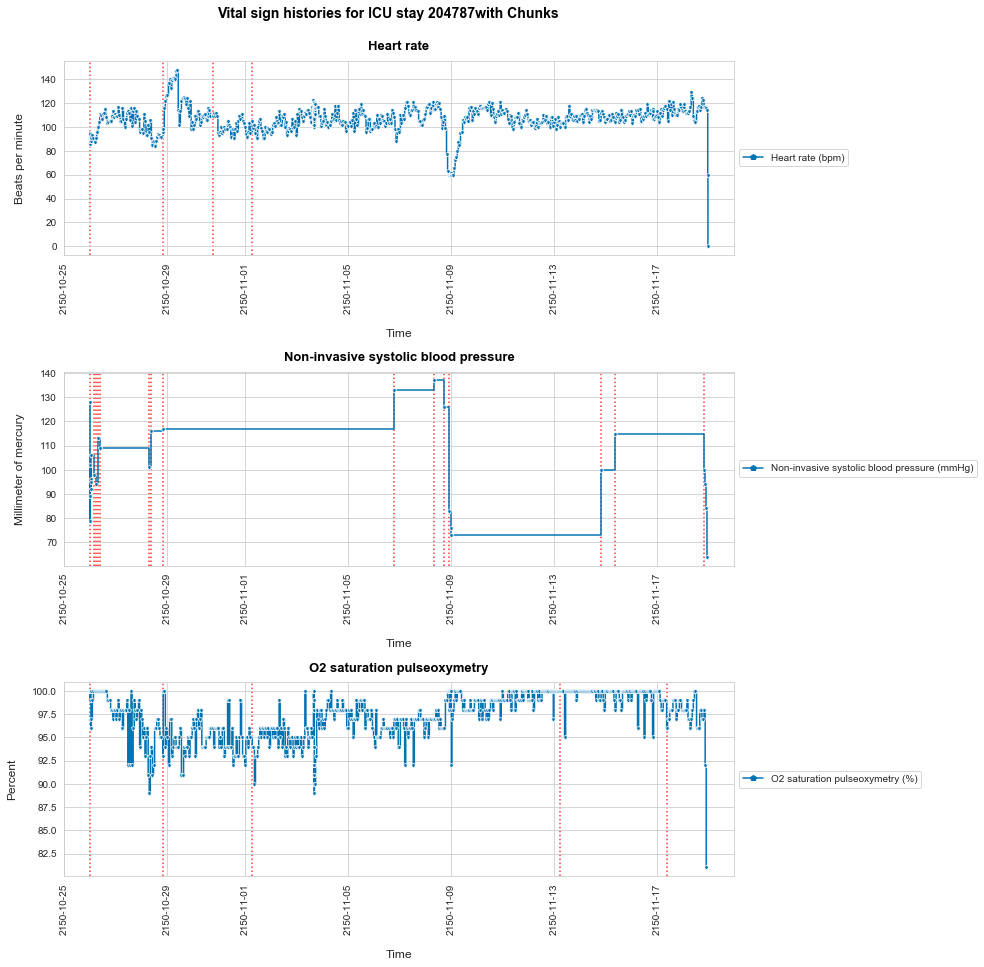

In [12]:
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

# Set shared variables
fig_title = "Vital sign histories for ICU stay "
xlabel = "Time"
huevalue = "ITEMID_LABEL"

# Set heart rate variables
hr_title = "Heart rate"
hr_ylabel = "Beats per minute"

# Set blood pressure variables
bp_title = "Non-invasive systolic blood pressure"
bp_ylabel = "Millimeter of mercury"

# Set O2 saturation variables
o2_title = "O2 saturation pulseoxymetry"
o2_ylabel = "Percent"

for icustay in icustayid_filter:

    # Set variables
    xlimits = [plotdata[plotdata['ICUSTAY_ID'] == icustay].CHARTTIME.min()-pd.Timedelta('1 day'), plotdata[plotdata['ICUSTAY_ID'] == icustay].CHARTTIME.max()+pd.Timedelta('1 day')]

    # Config figure
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(
        3,
        1,
        figsize = (12, 15), 
        # sharex = True, 
        dpi = 72 # e.g. 72 for screen, 300 for print
        )
    fig.suptitle(str(fig_title+str(icustay)+ "with Chunks"), fontweight='bold', color= 'black', fontsize=14, y=0.93)
    fig.subplots_adjust(hspace = 0.6)

    # Heart rate plot
    ax = sns.lineplot(
        ax = axs[0],
        data = plotdata[(plotdata['ITEMID'].isin([220045])) & (plotdata['ICUSTAY_ID'] == icustay)], 
        x = "CHARTTIME",
        y = "VALUENUM", 
        hue = huevalue,
        style= huevalue,
        drawstyle = 'steps-post', # Interpolate missing values by using the last available value
        markers = ['p'#,'^','v'
        ],
        markersize = 5,
        dashes = False,
        palette = [sns.color_palette("colorblind")[0]#,sns.color_palette("colorblind")[1],sns.color_palette("colorblind")[2]
        ]
        )
    

    chunks_of_selected_icustay_HR = chunks_of_selected_icustays[(chunks_of_selected_icustays['ICUSTAY_ID'] == icustay) & (chunks_of_selected_icustays['ITEMID'] == 220045)]
    # Create time indexed series
    chunks_of_selected_icustay_HR_series = chunks_of_selected_icustay_HR[['CHARTTIME_CHUNK','VALUENUM']].set_index('CHARTTIME_CHUNK').squeeze()
        
    for chunk_idx in range(len(chunks_of_selected_icustay_HR)):
          axs[0].axvline(
                chunks_of_selected_icustay_HR_series.index[chunk_idx],
                linestyle='dotted',
                color='r',
                alpha=0.8,
                zorder=0)

    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].set_xlim(xlimits)
    axs[0].set_title(hr_title, fontweight='bold', color= 'black', fontsize=13, y=1.025)
    axs[0].set_xlabel(xlabel, fontsize=12, labelpad=15)
    axs[0].set_ylabel(hr_ylabel, fontsize=12, labelpad=15)
    axs[0].tick_params(axis="x", rotation=90)

    # Blood pressure plot
    ax = sns.lineplot(
        ax = axs[1],
        data = plotdata[(plotdata['ITEMID'].isin([220179])) & (plotdata['ICUSTAY_ID'] == icustay)], 
        x = "CHARTTIME",
        y = "VALUENUM", 
        hue = huevalue,
        style= huevalue,
        drawstyle = 'steps-post', # Interpolate missing values by using the last available value
        markers = ['p'#,'^','v'
        ],
        markersize = 5,
        dashes = False,
        palette = [sns.color_palette("colorblind")[0]#,sns.color_palette("colorblind")[1],sns.color_palette("colorblind")[2]
        ]
        )
    # plt.legend(title = None, bbox_to_anchor=(1.02, 0.3), loc='upper left', borderaxespad=0)
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].set_xlim(xlimits) 
    axs[1].set_title(bp_title, fontweight='bold', color= 'black', fontsize=13, y=1.025)
    axs[1].set_xlabel(xlabel, fontsize=12, labelpad=15)
    axs[1].set_ylabel(bp_ylabel, fontsize=12, labelpad=15)
    axs[1].tick_params(axis="x", rotation=90)

    chunks_of_selected_icustay_NBP = chunks_of_selected_icustays[(chunks_of_selected_icustays['ICUSTAY_ID'] == icustay) & (chunks_of_selected_icustays['ITEMID'] == 220179)]    
    chunks_of_selected_icustay_NBP_series = chunks_of_selected_icustay_NBP[['CHARTTIME_CHUNK','CHUNK_ID']].set_index('CHARTTIME_CHUNK').squeeze()
    
    for chunk_idx in range(len(chunks_of_selected_icustay_NBP)):
          axs[1].axvline(
                chunks_of_selected_icustay_NBP_series.index[chunk_idx],
                linestyle='dotted',
                color='r',
                alpha=0.8,
                zorder=0)

    # O2 saturation plot
    ax = sns.lineplot(
        ax = axs[2],
        data = plotdata[(plotdata['ITEMID'].isin([220277])) & (plotdata['ICUSTAY_ID'] == icustay)], 
        x = "CHARTTIME",
        y = "VALUENUM", 
        hue = huevalue,
        style= huevalue,
        drawstyle = 'steps-post', # Interpolate missing values by using the last available value
        markers = ['p'#,'^','v'
        ],
        markersize = 5,
        dashes = False,
        palette = [sns.color_palette("colorblind")[0]#,sns.color_palette("colorblind")[1],sns.color_palette("colorblind")[2]
        ]
        )
    axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[2].set_xlim(xlimits) 
    axs[2].set_title(o2_title, fontweight='bold', color= 'black', fontsize=13, y=1.025)
    axs[2].set_xlabel(xlabel, fontsize=12, labelpad=15)
    axs[2].set_ylabel(o2_ylabel, fontsize=12, labelpad=15)
    axs[2].tick_params(axis="x", rotation=90)
    
    chunks_of_selected_icustay_O2 = chunks_of_selected_icustays[(chunks_of_selected_icustays['ICUSTAY_ID'] == icustay) & (chunks_of_selected_icustays['ITEMID'] == 220277)] 
    chunks_of_selected_icustay_O2_series = chunks_of_selected_icustay_O2[['CHARTTIME_CHUNK','CHUNK_ID']].set_index('CHARTTIME_CHUNK').squeeze()   
    
    for chunk_idx in range(len(chunks_of_selected_icustay_O2)):
          axs[2].axvline(
                chunks_of_selected_icustay_O2_series.index[chunk_idx],
                linestyle='dotted',
                color='r',
                alpha=0.8,
                zorder=0)

    # Save plot as PNG file
    #path = '../plots/'
    #timestamp = dt.datetime.today().strftime('%Y-%m-%dT%H-%M-%S')
    #plt.savefig(str(path + 'icustay-' + str(icustay) + '_time-series-multi-plot_72-DPI_' + timestamp + '.png'), dpi=72, bbox_inches='tight')
    #plt.savefig(str(path + 'icustay-' + str(icustay) + '_time-series-multi-plot_300-DPI_' + timestamp + '.png'), dpi=300, bbox_inches='tight')

    # Plot figure
    plt.show(fig)